In [174]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


In [175]:
import pennylane as qml
from pennylane import numpy as np


def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

In [176]:
def add_k_sign(k, wires):
    
    #sign handling
    k = int(np.binary_repr(k,len(wires)),2)
    
    qml.QFT(wires=wires)
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
    qml.adjoint(qml.QFT)(wires=wires)

In [177]:
wires_m = [0, 1, 2]           # qubits needed to encode m
wires_k = [3, 4, 5]           # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10,11,12,13]  # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1024)

n_wires = len(dev.wires)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


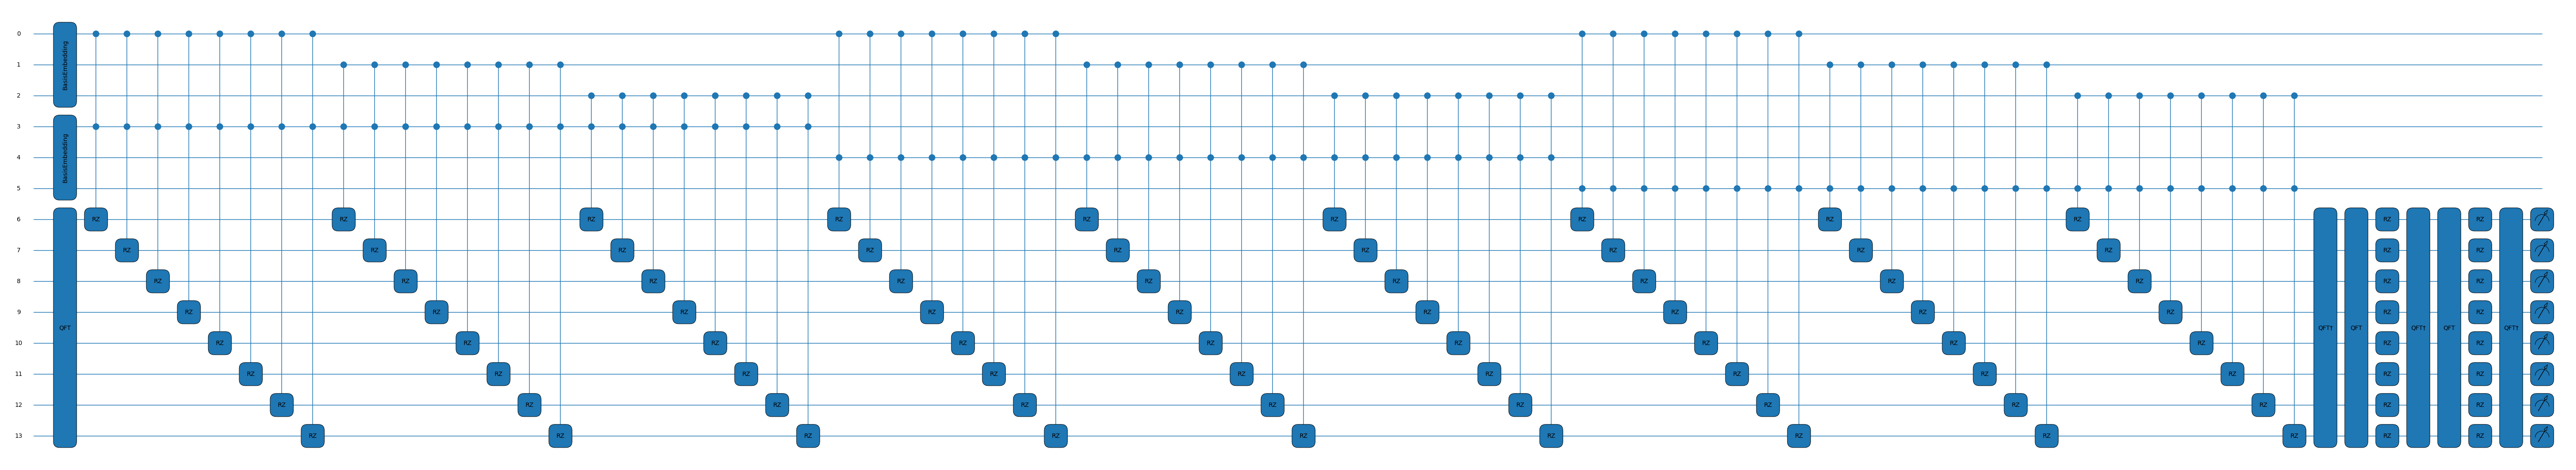

In [178]:
def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def circuit(m_k_a_t):
    m, k,a,t = m_k_a_t
    
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # Apply circuittiplication
    multiplication(wires_m, wires_k, wires_solution)
    add_k_sign(a,wires=wires_solution)
    
    add_k_sign(t,wires=wires_solution)
    
    return qml.probs(wires=wires_solution)

input = (2,3,2,1)

res = circuit(input)

print(res)

qml.draw_mpl(circuit, show_all_wires=True)(input)
plt.show()

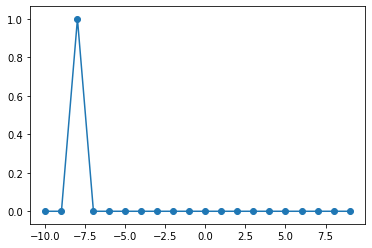

In [179]:

x=[i for i in range(-10,10)]
y=[]
for i in x:
    # print('===')
    # print(circuit((2,3,2,i)))
    y.append(circuit((2,3,2,i))[0])

# plot scatter plot with x and y data
plt.scatter(x, y)
  
# plot with x and y data
plt.plot(x, y)

